# Spectroscopic Data Reduction Part 2: Wavelength Calibration

This notebook assumes you've completed the Spectroscopic Trace process (see [Part 1](1-SpectroscopicTraceTutorial.ipynb)) and have a trace model handy.

## Authors
Adam Ginsburg, Kelle Cruz, Lia Corrales, Jonathan Sick, Adrian Price-Whelan

## Learning Goals
* Extract calibration lamp spectra from two-dimensional spectral images
* Fit a wavelength solution


## Keywords
Spectroscopy

## Summary
This tutorial will walk through extraction of a calibration lamp spectrum using an existing trace.

It will then demonstrate line identification using the NIST line list database.

Finally, it will show how to fit a wavelength solution to a calibration spectrum, integrating information from multiple calibration lamps.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
IPython
numpy
pillow
matplotlib



In [2]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'  # we want to show images, not matrices, so we set the origin to the lower-left
plt.style.use('dark_background')  # Optional configuration: if run, this will look nice on dark background notebooks

In [3]:
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist

We have three calibration lamp spectra: Mercury, Krypton, and Neon.  These are saved as .bmp (bitmap) files.

In [4]:
hg_filename = "hg_lamp_1-sixteenth_s.bmp"
kr_filename = "kr_lamp_p6.bmp"
ne_filename = "ne_lamp_1s.bmp"

In [5]:
hg_image = np.array(PILImage.open(hg_filename))
kr_image = np.array(PILImage.open(kr_filename))
ne_image = np.array(PILImage.open(ne_filename))

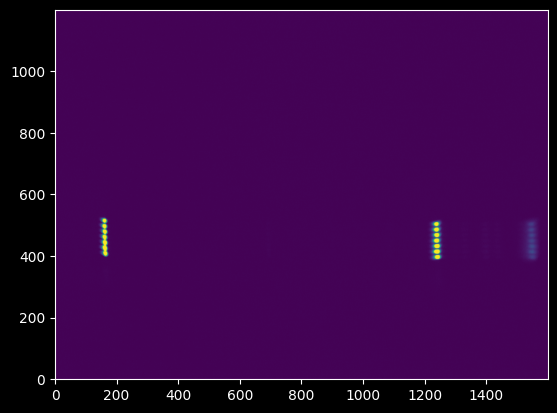

In [6]:
plt.imshow(hg_image);

In [ ]:
plt.imshow(kr_image);

In [ ]:
plt.imshow(ne_image);

We can note by zooming in that there appear to be seven independent spectra:

In [ ]:
plt.imshow(hg_image[380:540,140:180]);

We re-create our trace model from the [Spectroscopic Trace Tutorial](Spectroscopic%20Trace%20Tutorial.ipynb) using the fitted models.

(We could have used the empirical trace directly, which might result in slightly improved noise characteristics, but for simplicity - and to make the two notebooks independently usable - we use the fitted polynomial & Gaussian models here)

In [ ]:
trace_model = Polynomial1D(degree=3, c0=453.6307, c1=-0.01596396, c2=0.0000008259, c3=3.3348554642250357e-09)
trace_profile_model = Gaussian1D(amplitude=123.84846797, mean=0.17719819, stddev=5.10872134)
xaxis = np.arange(hg_image.shape[1])
trace_center = trace_model(xaxis)
npixels_to_cut=15
yaxis = np.arange(-npixels_to_cut, npixels_to_cut)
model_trace_profile = trace_profile_model(yaxis)

Then, we use the trace to extract spectra from each of the three calibration lamp spectra.

We verify that the traces look acceptable first, though:

In [ ]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(3,1,1)
ax1.imshow(hg_image[430:470,:], extent=[0,1600,430,470])
ax1.plot(xaxis, trace_center)
ax1.set_aspect(10)
ax2 = plt.subplot(3,1,2)
ax2.imshow(kr_image[430:470,:], extent=[0,1600,430,470])
ax2.plot(xaxis, trace_center)
ax2.set_aspect(10)
ax3 = plt.subplot(3,1,3)
ax3.imshow(ne_image[430:470,:], extent=[0,1600,430,470])
ax3.plot(xaxis, trace_center)
ax3.set_aspect(10)

Strangely, the trace looks like it's going through a minimum between the individual spectra, which may indicate that the spectrograph was shaken or jiggled between the trace and wavelength calibration observations.  Nevertheless, there's enough signal that we can extract a calibration lamp spectrum, and the trace is perpendicular enough to the dispersion axis that we can mostly trust it. 

In the following three cells, we extract the trace-profile-weighted average spectrum from each of the three calibration lamps.  

``npixels_to_cut`` sets a cutout region around the trace, close to what is shown in the figures above.  The ``model_trace_profile``, derived earlier, is the transmission profile we measured using the stellar trace.  

In [ ]:
hg_spectrum = np.array([np.average(hg_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [ ]:
ne_spectrum = np.array([np.average(ne_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [ ]:
kr_spectrum = np.array([np.average(kr_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [ ]:
plt.plot(xaxis, hg_spectrum, label='Mercury')
plt.plot(xaxis, ne_spectrum, label='Neon')
plt.plot(xaxis, kr_spectrum, label='Krypton')
plt.legend(loc='best');

We now have spectra of a mercury lamp, a neon lamp, and a krypton lamp.

If we have no prior knowledge, we would have to do some guess-and-check.  It helps to do _educated_ guess-and-check, though; wikipedia is a decent resource to point us at the right line lists:

 * https://en.wikipedia.org/wiki/Mercury-vapor_lamp#Emission_line_spectrum
 * https://en.wikipedia.org/wiki/Gas-discharge_lamp#Color

In [ ]:
from IPython.display import Image, display
import requests

Image("https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg")

Image("https://upload.wikimedia.org/wikipedia/commons/9/99/Neon_spectra.jpg")

Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Krypton_Spectrum.jpg")

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers, timeout=15)
r.raise_for_status()              # lanza error si no es 200
display(Image(data=r.content))    # muestra el binario directamente


In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/9/99/Neon_spectra.jpg"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers, timeout=15)
r.raise_for_status()              # lanza error si no es 200
display(Image(data=r.content))    # muestra el binario directamente


In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/a/a6/Krypton_Spectrum.jpg"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers, timeout=15)
r.raise_for_status()              # lanza error si no es 200
display(Image(data=r.content))    # muestra el binario directamente


Start with mercury.  We use a different wikipedia spectrum that looks a little more like ours to guide the eye (note that the line ratios vary from lamp to lamp at least partly because each lamp contains gas at a different pressure).

In [ ]:
Image("https://upload.wikimedia.org/wikipedia/commons/0/0d/HG-Spektrum_crop.jpg")

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/0/0d/HG-Spektrum_crop.jpg"
headers = {"User-Agent": "Mozilla/5.0"}

r = requests.get(url, headers=headers, timeout=15)
r.raise_for_status()              # lanza error si no es 200
display(Image(data=r.content))    # muestra el binario directamente

The optical lines of Mercury are, from Wikipedia, in Angstroms:

 * 4047 violet
 * 4358 blue
 * 5461 green
 * 5782 yellow-orange
 * 6500 red

In [ ]:
plt.plot(xaxis, hg_spectrum);

At this next step, we have to write down which (approximate) pixel values correspond to known wavelengths.

Guessing these just by looking at the spectra and comparing to spectral atlases is hard and takes experience.

If you have spectra taken with the same setup of a known sources - such as an A0 star - you might be able to use that to give you a 'prior' on where the spectrum is centered.
In this case, our set of spectra include Deneb, which is an A-star.  It has a clear absorption line (that we'll see later, in tutorial 3) around pixel 750.
A-stars have deep hydrogen absorption lines in their atmosphere and little else, so this is probably a hydrogen line.
We can assume it's either H-alpha or H-beta, since they are both in the optical and strong (higher lines, like H-delta, are all close together, so if it were one of them, we'd expect to see several adjacent lines).

We can therefore compare our spectrum to the atlases assuming pixel 750 is H-beta or H-alpha.  Using the line list, we can see red is pretty unlikely: H-alpha is at 6563, so there would be a line right next to it.  If it's H-beta, there are lines on either side, and there is a doublet on the right side.  

The next trick is figuring out which way the wavelength increases - to the left or the right?  Mercury doesn't help with that, since the blue-violet and green-yellow doublets are about the same distance from one another.  It turns out, from guess-and-check work, that wavelength is increasing to the left.

Again, this part is hard to do directly from the data - you generally hope to have a pretty good idea of what wavelength you're observing before you observe!

In [ ]:
guessed_wavelengths = [546.1, 435.8, 404.7]
guessed_xvals = [165, 1230, 1550]

## Improving on our guesses

We can do a lot better at determining the pixel X-values by taking the intensity-weighted coordinate (moment 1):

In [ ]:
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=hg_spectrum[g-npixels:g+npixels] - np.median(hg_spectrum))
                         for g in guessed_xvals]
improved_xval_guesses

In [ ]:
plt.plot(xaxis, hg_spectrum, label='Espectro Hg')
plt.plot(guessed_xvals, [100]*3, 'rx', label='Estimación inicial')
plt.plot(improved_xval_guesses, [100]*3, 'g+', label='Centro refinado')
plt.legend()
plt.xlabel('Píxel')
plt.ylabel('Intensidad')
plt.show()

We only have three data points, but that is enough to fit a linear model and still have a free point to check that we got it close to right:

In [ ]:
linfitter = LinearLSQFitter()

We use a `Linear1D` model because we will want to use its inverse later (other models are not invertible)

In [ ]:
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(xaxis) * u.nm
linfit_wlmodel

Note this fitted slope: each pixel is about 0.1 nm (about 1 angstrom), and the wavelength increases to the left.

In [ ]:
plt.plot(wavelengths, hg_spectrum)
plt.plot(guessed_wavelengths, [100]*3, 'x');

We show our model $\lambda(x)$ vs the input "guesses":

In [ ]:
plt.plot(improved_xval_guesses, guessed_wavelengths, 'o')
plt.plot(xaxis, wavelengths, '-')
plt.ylabel(r"$ \lambda(x) $")
plt.xlabel("x (pixels)")

Indeed, a linear model fit excellently!

We can look up neon and krypton line lists to see how well we did and maybe try to improve our fit.

NIST, the National Institute of Standards and Technology, maintains [atomic line lists](https://physics.nist.gov/PhysRefData/ASD/lines_form.html).  However, we have no direct way to know which transitions from these atoms to use!  There are a few heuristics we can apply, though.

In [ ]:
# we adopt the minimum/maximum wavelength from our linear fit
minwave = wavelengths.min()
maxwave = wavelengths.max()
# then we search for atomic lines
# We are only interested in neutral lines, assuming the lamps are not hot enough to ionize the atoms
mercury_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Hg I')
krypton_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Kr I')
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        linename='Ne I')

We can first look at what NIST reports for the mercury spectrum we already fit:

(note that the wavelengths are *air* wavelengths, not vacuum)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(wavelengths, hg_spectrum, color='deepskyblue')
plt.vlines(mercury_lines['Observed'], 0, max(hg_spectrum)*0.9, 
           color='white', alpha=0.3, lw=1.2)
plt.xlabel(r"Wavelength $\lambda$ (Å)")
plt.ylabel("Intensity (a.u.)")
plt.title("Mercury Lamp Spectrum and NIST Reference Lines")
plt.show()


The database contains *many* more lines than we saw.

The "Rel. Int" (Relative Intensity) provides "a qualitative description of what the emission spectrum of a particular element in a particular (low-density) source looks like." 

We can select that column, if we clean it up a little (there are some "blank" entries)

## Ejercicicos

Realizar la calibración de las fotos de espectros anexas del He, Kr, Hg y Ne


You're done!  Now apply this calibration to the data and start measuring things in Tutorial 3